In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
import tensorflow as tf

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot as plt
%matplotlib inline

# imports from our libreries
import sampling as sp
from datasets import spirals
from utils import define_loss
from utils import LambdaParameter
from models import FeedForwardModel
from sequential_copy import sequential_train

## 1. Create original problem

#### 1.1 Create original dataset

In [2]:
# Create new problem
#X, y = make_moons(**{'n_samples':1500, 'shuffle':True, 'noise':0.2, 'random_state':42})
X, y = spirals(1500)
X = StandardScaler(copy=True).fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=7)

#### 1.2 Train original model

In [3]:
# Fit model
original = RandomForestClassifier(n_estimators=50, criterion='gini', n_jobs=1, max_depth=None, random_state=42)
original.fit(X_train, y_train)

y_test_pred = original.predict(X_test)
acc = np.average(np.where(y_test_pred==y_test,1.,0.))
print('A0:', acc)

A0: 0.9966666666666667


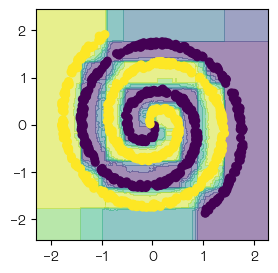

In [4]:
# Define domain
min_, max_ = np.min(X_train-0.5, axis=0), np.max(X_train+0.5, axis=0)
xx, yy = np.meshgrid(np.arange(min_[0], max_[0], .025), np.arange(min_[1], max_[1], .025))
z = original.predict_proba(np.hstack([xx.reshape(-1, 1), yy.reshape(-1, 1)]))[:,0].reshape(xx.shape)

# Initialize figure
fig = plt.figure(figsize=(3,3)) 
ax = fig.add_subplot(111)
ax.contourf(xx, yy, z, alpha=0.5)
plot = ax.scatter(X_test[:,0], X_test[:,1], c=-y_test, s=30)

## 2. Train single copy model

In [5]:
# define optimizer and loss 
opt = tf.keras.optimizers.Adam(learning_rate=0.0005)
loss = define_loss(2, loss_name = 'UncertaintyError')

# define new model
seq_copy = FeedForwardModel(input_dim=2, hidden_layers=[64,32,10], output_dim=2, activation='relu')
seq_copy.build(input_shape=(64,2))
seq_copy.compile(loss=loss, optimizer=opt)

# define the memory (lambda) parameter
lmda = LambdaParameter(lmda=0.1, automatic_lmda=False)

#define the sampling process
sampler = sp.Sampler(balancer = False)

In [55]:
# fit copy model
trained_model = sequential_train(seq_copy, 
                                 sampler, 
                                 original, 
                                 n_samples_iter=100, 
                                 thres=1e-9, 
                                 lmda_par = lmda,
                                 max_iter=3, 
                                 X_test=X_test, 
                                 y_test=y_test, 
                                 sample_selection=True,
                                plot_every=False)

In [56]:
print(trained_model.acc_test)
print(trained_model.n)
print(trained_model.acc_train)
print(trained_model.rho)
print(trained_model.lmda_vector)

ListWrapper([0.6722222222222223, 0.8922222222222222, 0.96, 0.96, 0.9333333333333333, 0.9266666666666666])
ListWrapper([100, 174, 202, 52, 106, 153])
ListWrapper([1.0, 0.9942528735632183, 0.995049504950495, 1.0, 1.0, 0.9934640522875817])
ListWrapper([0.010053128507601441, 0.006139574473227782, 0.005607089873136014, 0.001857082376631604, 0.00043598187577593983, 0.006788817556935196])
ListWrapper([0.1, 0.1, 0.1, 0.1, 0.1, 0.1])


1110/1110 [==============================] - 2s 2ms/step


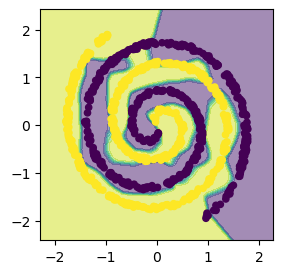

In [57]:
z = trained_model.predict(np.hstack([xx.reshape(-1, 1), yy.reshape(-1, 1)]))[:,0].reshape(xx.shape)

fig = plt.figure(figsize=(3,3)) 
ax = fig.add_subplot(111)
ax.contourf(xx, yy, z, alpha=0.5)
ax.scatter(X_test[:,0], X_test[:,1], c=-y_test, s=20)
plt.show()

## 3. Train multiple copy models in parallel

In [58]:
from joblib import Parallel, delayed

# CAMBIAR SEQUENTIAL TRAIN PARA QUE NO HAGA LAS FIGURAS POR DEFAULT!

def separate_runs(original, 
                  n_samples_iter=100, 
                  thres=1e-9, 
                  lmda_par = lmda,
                  max_iter=3, 
                  X_test=X_test, 
                  y_test=y_test, 
                  sample_selection=True):
    
    # define optimizer and loss 
    opt_ = tf.keras.optimizers.Adam(learning_rate=0.0005)
    loss_ = define_loss(2, loss_name = 'UncertaintyError')

    # define new model
    seq_copy_ = FeedForwardModel(input_dim=2, hidden_layers=[64,32,10], output_dim=2, activation='relu')
    seq_copy_.build(input_shape=(64,2))
    seq_copy_.compile(loss=loss_, optimizer=opt_)

    # define the memory (lambda) parameter
    lmda_ = LambdaParameter(lmda=0.1, automatic_lmda=False)

    #define the sampling process
    sampler_ = sp.Sampler(balancer=False)
    
    return sequential_train(seq_copy_, 
                            sampler_, 
                            original, 
                            n_samples_iter=50, 
                            thres=1e-9, 
                            lmda_par =lmda_,
                            max_iter=3, 
                            X_test=X_test, 
                            y_test=y_test, 
                            sample_selection=True,
                            plot_every=False)

In [59]:
n_runs = 3
results = Parallel(n_jobs=-1, backend='threading')(delayed(separate_runs)(original 
                                           )  for i in range(0, n_runs))

In [63]:
def decode_results(data):
    n, acc_train, acc_test, rho, lmda = ([] for i in range(5))
    
    for i in range(len(data)):
        n.append(list(data[i].n))
        acc_train.append(list(data[i].acc_train))
        acc_test.append(list(data[i].acc_test))
        rho.append(list(data[i].rho))
        lmda.append(list(data[i].lmda_vector))
        
    return np.array(n), np.array(acc_train), np.array(acc_test), np.array(rho), np.array(lmda)

In [64]:
n, acc_train, acc_test, rho, lmda_vector = decode_results(results)

In [5]:
##### -------
n, acc_train, acc_test, rho, lmda_vector = (np.array([[ 50,  77, 109],
        [ 50,  82, 109],
        [ 50,  82, 102]]),
 np.array([[1.        , 1.        , 1.        ],
        [1.        , 1.        , 0.99082569],
        [1.        , 1.        , 0.94117647]]),
 np.array([[0.59888889, 0.67888889, 0.84      ],
        [0.55      , 0.68444444, 0.70333333],
        [0.61666667, 0.77      , 0.73444444]]),
 np.array([[0.0026422 , 0.00051347, 0.00017135],
        [0.00169434, 0.01192237, 0.01056969],
        [0.00071333, 0.00048053, 0.05901857]]),
 np.array([[0.1, 0.1, 0.1],
        [0.1, 0.1, 0.1],
        [0.1, 0.1, 0.1]]))

In [6]:
one_shot = np.array([[0.72, 0.75, 0.73], [0.79, 0.786, 0.775], [0.82, 0.85, 0.843]])

In [7]:
from plots import iteration_plot

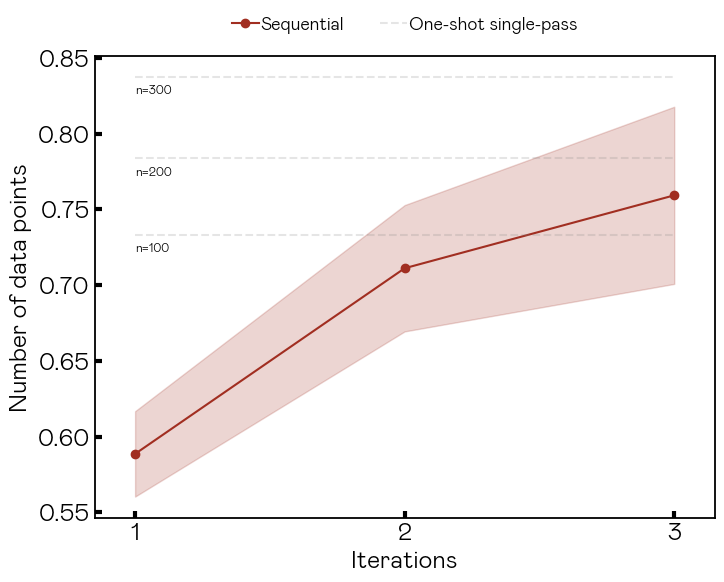

In [8]:
iteration_plot([acc_test], 
               ['Sequential'],
               ylabel='Number of data points',
               fill=True, 
               one_shot=one_shot)

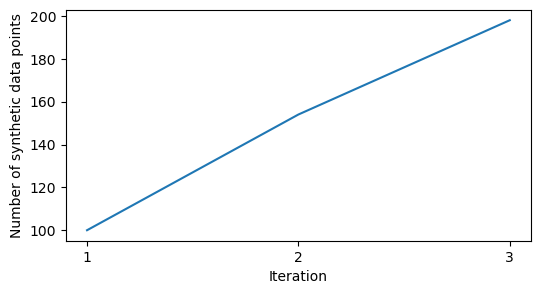

In [34]:
fig = plt.figure(figsize=(6,3)) 
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(trained_model.n)+1), trained_model.n)
ax.set_xticks(np.arange(1, len(trained_model.n)+1))
ax.set_xlabel('Iteration')
ax.set_ylabel('Number of synthetic data points')
plt.show()

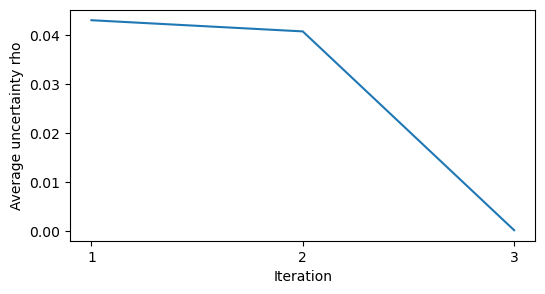

In [38]:
fig = plt.figure(figsize=(6,3)) 
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(trained_model.rho)+1), trained_model.rho)
ax.set_xticks(np.arange(1, len(trained_model.rho)+1))
ax.set_xlabel('Iteration')
ax.set_ylabel('Average uncertainty rho')
plt.show()

In [9]:
def sampler_tester():
    ## testing generation of synthetic data
    sampler = sp.Sampler(balancer = False)
    plotting_test(sampler, n=2000, title='Balancer False')
    sampler = sp.Sampler(balancer = True)
    plotting_test(sampler, n=2000, title='Balancer True')

    ## setting parameter to read from file
    file_name = 'test4.csv' # try non existent file_name
    sampler = sp.Sampler(from_file = True) # error
    plotting_test(sampler, n=2000, title='No file set, data generated')

    sampler = sp.Sampler(from_file = True, file_path = file_name) # error, you should set automatic_fill ti True
    plotting_test(sampler, n=2000, title='File does not exist. Data generated')

    sampler = sp.Sampler(from_file = True, file_path = file_name, automatic_fill=True) # works. File created
    plotting_test(sampler, n=2000, title='From file... but, it does not has data. Data generated')
    print('File', file_name, 'has 2000 points')

    ## reading from file
    sampler = sp.Sampler(from_file = True, file_path = file_name, automatic_fill=True) # works. File created
    plotting_test(sampler, n=2000, title='From file!')

def plotting_test(sampler, n=100, title=''):
    # plotting new synthetic data from the sample generator using original model
    X,y = sampler.get_samples(original, n)
    fig = plt.figure(figsize=(3,3)) 
    ax = fig.add_subplot(111)
    plot = ax.scatter(X[:,0], X[:,1], c=-y, s=20)
    ax.set_title(title)
    plt.show()